In [1]:
# pip install pydot

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import VGG16
from sklearn.metrics import *
import tensorflow.keras.backend as K
import os
import seaborn as sr
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import *
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *
from tqdm import tqdm
from tensorflow.keras import layers
# from tensorflow.keras.layers import 
from tensorflow.keras.callbacks import *
from tensorflow.keras import *
from Custom_Image_generator import *
from tensorflow.keras.applications import VGG16


In [20]:
vgg16_base = VGG16(include_top=False)
for layer in vgg16_base.layers[:-3]:
    layer.trainable = False
x = vgg16_base.output
x = Flatten()(x)
base_model = Model(inputs=vgg16_base.input, outputs=x)

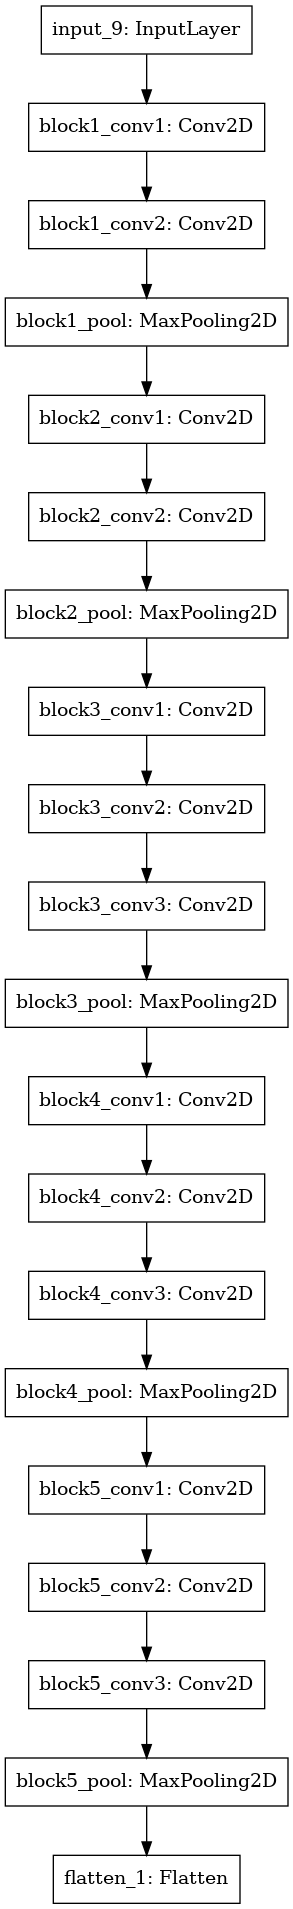

In [22]:
plot_model(base_model)

### Data Generator

In [3]:
path ="/media/kashraf/Elements/Dissertation/data/pouya_topomaps/beta/"
x_trainfiles = [get_img_label (path, interv,keyword="train")[0] for interv in range(1,8)]
y_train_files = get_img_label (path,1,keyword="train")[1]

x_testfiles = [get_img_label (path, interv,keyword="test")[0] for interv in range(1,8)]
y_test_files = get_img_label (path,1,keyword="test")[1]
print("Number of raining images:",x_trainfiles[0].shape)
print("Number of training labels:",y_train_files.shape)
print("Number of raining images:",x_testfiles[0].shape)
print("Number of training labels:",y_test_files.shape)
# train_gen = image_generator(x_trainfiles,y_train_files,1)

Number of raining images: (2116,)
Number of training labels: (2116,)
Number of raining images: (912,)
Number of training labels: (912,)


In [4]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, x_fnames,y_fnames,batch_size,target_size=(224, 224, 3),shuffle=True):
        
        self.x_fnames = x_fnames
        self.y_fnames = y_fnames
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.x_fnames[0].shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __process_batch(self,batch_files):
        interval_images = []
        for file in batch_files:
            image = tf.keras.preprocessing.image.load_img(file)
            image_arr = tf.keras.preprocessing.image.img_to_array(image)
            image_arr = tf.image.resize(image_arr,(self.target_size[0], self.target_size[1])).numpy()
            interval_images.append(image_arr/255)
        return interval_images
  
    
    def __get_data(self,batch_indexes):
        
        files = self.x_fnames
        
        # Select batch files and labels from all files 
        batch_files = [file[batch_indexes] for file in files] 
        
        batch_images = [np.array(self.__process_batch (batch)) 
                        for batch in batch_files]
        
        batch_labels = self.y_fnames[batch_indexes]
        batch_labels = to_categorical(batch_labels,num_classes=4)
        
        return batch_images,batch_labels

    
    def __getitem__(self, index):
        
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        x, y = self.__get_data(indexes)        
        return x, y
    
    def __len__(self):
        return int(np.floor(self.x_fnames[0].shape[0]) / self.batch_size)


In [5]:
train_gen = CustomDataGen(x_fnames=x_trainfiles,y_fnames=y_train_files,batch_size=16)
test_gen = CustomDataGen(x_fnames=x_testfiles,y_fnames=y_test_files,batch_size=16)
# len(train_gen.__getitem__(0)[0])

### Modelling

### PCA layer

In [6]:
class pca(Layer):
    def __init__(self, n_components = 1):
        super().__init__()
        self.g = None
        self.n_components = n_components
        
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'g': self.g,
            'n_components': self.n_components
        })
        return config
    
    @tf.function
    def call(self, X):
        
        m, p, q, n = X.shape
        X_r = tf.transpose(X, perm=[0,3,1,2])
        X_r = tf.reshape(X_r, (-1, p, q))
        if m != None:
            i=0
            if self.g is None:
                self.g = tf.Variable(tf.zeros((m*n, p, self.n_components)))
            
            for x in X_r:
                
                cov = tf.tensordot(x, x, axes=1)
                s, u, v = tf.linalg.svd(cov)
                U1 = u[:, 0:self.n_components]

                x_proj = tf.tensordot(x, U1, axes=1)
                
                self.g[i].assign(x_proj)
                i += 1
            return tf.reshape(self.g, (m, -1, n))
        
        return X[:, :, 0, :]
class pca_mean(Layer):
    def __init__(self, n_components = 1):
        super().__init__()
        self.g = None
        self.n_components = n_components
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'g': self.g,
            'n_components': self.n_components
        })
        return config
    
    @tf.function
    def call(self, X):
        m, p, q, n = X.shape
        if m != None:
            i=0
            if self.g is None:
                pca_layer = pca()
                
                self.g = pca_layer(X)
                return tf.reduce_mean(self.g, axis=1)
        
        return X[:, 0, 0, :]

### Patch encoder

In [7]:
class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection': self.projection,
            'position_embedding':self.position_embedding
        })
        return config
    @tf.function
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### Feed forward block

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Hyperparameter setup

In [9]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
# Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers 
#of the final classifier


#### CNN block

In [10]:
img_shape = (224,224,3)
def get_model(shape):
    inputs=Input(shape=shape)
    
    # First conv layer
    x = Conv2D(32, (7, 7), padding="same",kernel_regularizer=l2(0.01))(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    
     # Second conv layer
    x = Conv2D(64, (5, 5), padding = "same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(32, (5, 5), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
   
    
    x = Conv2D(96, (3, 3), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
   
    
    x = Conv2D(96, (3, 3), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    
    x = pca()(x)
    outputs= Flatten()(x)
    return Model(inputs, outputs)

def create_EEG_transformer():

    models = [get_model(shape=img_shape)]*7
    input1 = Input(shape=img_shape,name="int_1")
    input2 = Input(shape=img_shape,name="int_2")
    input3 = Input(shape=img_shape,name="int_3")
    input4 = Input(shape=img_shape,name="int_4")
    input5 = Input(shape=img_shape,name="int_5")
    input6 = Input(shape=img_shape,name="int_6")
    input7 = Input(shape=img_shape,name="int_7")
    inputs = [input1,input2,input3,input4,input5,input6,input7]
    
    # Extract output of CNN models and stack them
    ys=[models[i](inputs[i]) for i in range(len(inputs))]
    ys= tf.stack(ys,axis=1)
    
    # Call path encoder and add position encoding
    encoded_patches = PatchEncoder(num_patches =7, projection_dim=projection_dim)(ys)
    
    # Add multihead Attention block
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        
        # OG drouout was 0.1
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.3
        )(x1, x1)
        
        # Skip connection 1.
        x2 = Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        # OG drouout was 0.1
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.4)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)
    representation = Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = Dense(4,activation="softmax",name="class")(features)
    # Create the Keras model.
    model = Model(inputs=inputs, outputs=logits)
    model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])
    
    return model
    
    
    
    


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-11-16 21:42:33.385252: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-16 21:42:33.388088: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-16 21:42:33.461086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 21:42:33.461379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-11-16 21:42:33.461417: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-16 21:42:33.463870: I tensorflow/stream_executor/platfor

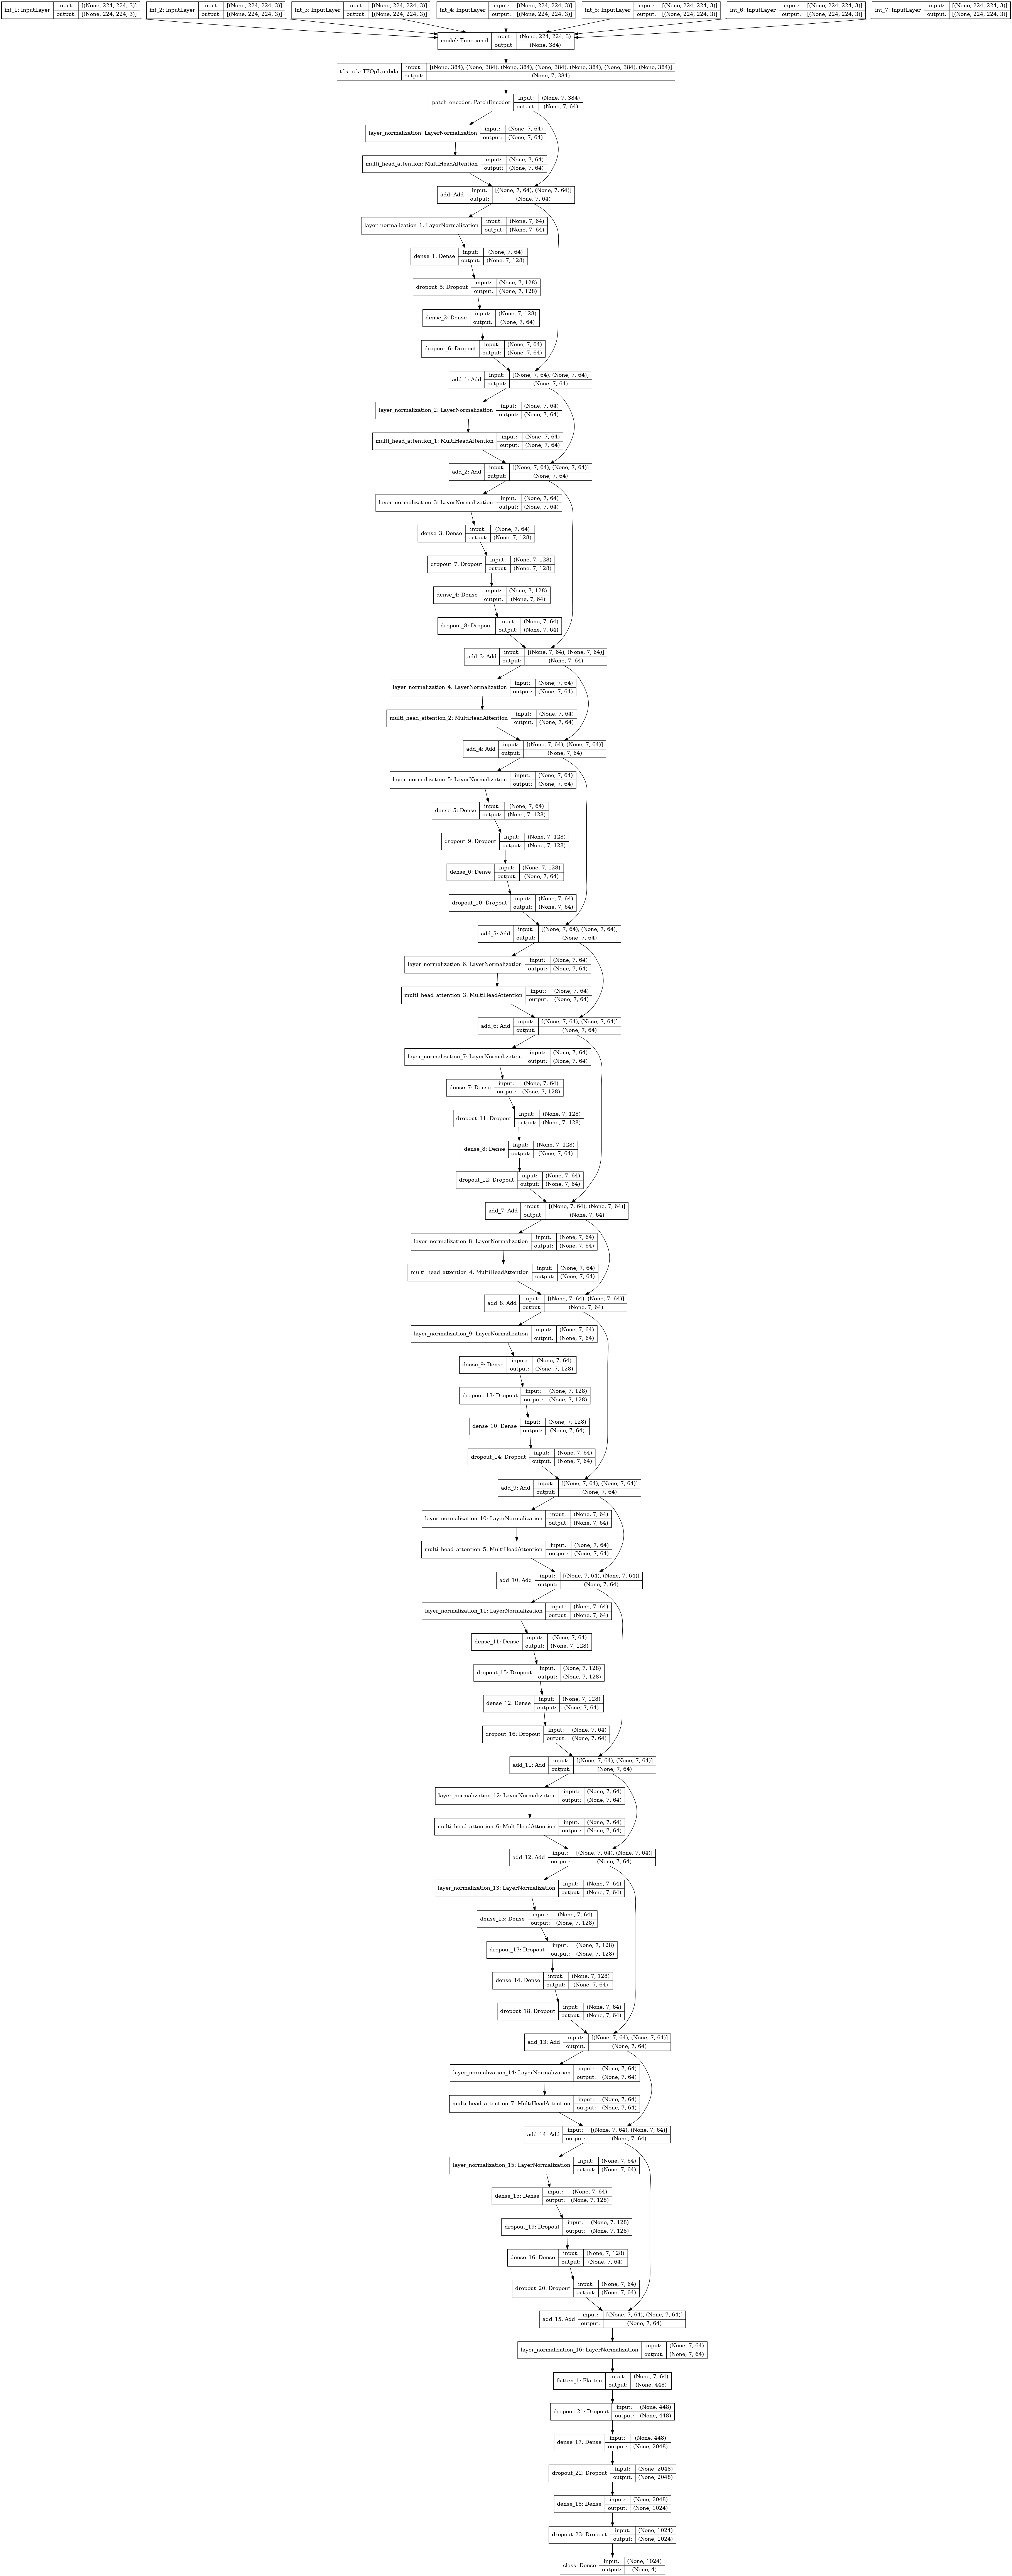

In [11]:
res_dir = "/media/kashraf/Elements/Dissertation/modelling/General/results"
model=create_EEG_transformer()
plot_model(model,show_shapes=True,to_file= os.path.join(res_dir,"EEG_Transfromer.png"))
# model.summary()


## Custom data generator

In [12]:
def load_data(ids,path):
    X = []
    Y = []
    np.random.shuffle(ids)

    for i in tqdm(ids):

        x2 = np.load(os.path.join(path,
                                  "cl2",os.listdir(path+"/"+"cl2")[i]))
        x4 = np.load(os.path.join(path,
                                  "cl4",os.listdir(path+"/"+"cl4")[i]))
        x6 = np.load(os.path.join(path,
                                  "cl6",os.listdir(path+"/"+"cl6")[i]))
        x8 = np.load(os.path.join(path,
                                  "cl8",os.listdir(path+"/"+"cl8")[i]))

        X.append([x2,x4,x6,x8])
        Y.append([0,1,2,3])

    return np.concatenate(X)/255, np.concatenate(Y)

def batch_generator(ids,path, batch_size = 4):
    batch=[]
    while True:
            np.random.shuffle(ids) 
            for i in ids:
                batch.append(i)
                if len(batch)==batch_size:
                    yield load_data(batch,path)
                    batch=[]


### Training

In [13]:
# from tqdm import tqdm

# data_path = "/media/kashraf/Elements/Dissertation/data/preprocessed/visual/interval_topos/beta/all_intervals/train/"
# ids=np.arange(0,545)
# data_gen=load_data(ids,data_path)

# test_path = "/media/kashraf/Elements/Dissertation/data/preprocessed/visual/interval_topos/beta/all_intervals/test/"
# ids_test =  np.arange(0,234)
# x_test,y_test1 = load_data(ids_test,test_path)

In [14]:
# x_test.shape

In [15]:
# print("X_train: ", data_gen[0].shape)
# print("X_est: ", x_test.shape)
# print("y_train: ", data_gen[1].shape)
# print("y_test: ", y_test1.shape)

In [16]:
weight_dir = "/media/kashraf/Elements/Dissertation/modelling/General/weights/"
# model.save_weights(os.path.join(weight_dir,"EEG_Transformer_CNN_betaV1.h5"))           
checkpoint = ModelCheckpoint(os.path.join(weight_dir,"EEG_Transformer_CNN_betaV1.h5"),
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.000001)

# we put our call backs into a callback list
callbacks = [ checkpoint]

In [ ]:


history= model.fit(train_gen,epochs = 500,validation_data=test_gen,callbacks=callbacks)


2022-11-16 21:42:37.210807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-16 21:42:37.231706: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz


Epoch 1/500


2022-11-16 21:42:43.832425: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-16 21:42:44.482846: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


132/132 [==============================] - 128s 911ms/step - loss: 5.3370 - accuracy: 0.2564 - val_loss: 4.3508 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 4.35078, saving model to /media/kashraf/Elements/Dissertation/modelling/General/weights/EEG_Transformer_CNN_betaV1.h5
Epoch 2/500
132/132 [==============================] - 119s 900ms/step - loss: 4.1581 - accuracy: 0.2602 - val_loss: 3.4551 - val_accuracy: 0.2500

Epoch 00002: val_loss improved from 4.35078 to 3.45514, saving model to /media/kashraf/Elements/Dissertation/modelling/General/weights/EEG_Transformer_CNN_betaV1.h5
Epoch 3/500
132/132 [==============================] - 118s 898ms/step - loss: 3.2897 - accuracy: 0.2445 - val_loss: 2.7440 - val_accuracy: 0.2500

Epoch 00003: val_loss improved from 3.45514 to 2.74402, saving model to /media/kashraf/Elements/Dissertation/modelling/General/weights/EEG_Transformer_CNN_betaV1.h5
Epoch 4/500
132/132 [==============================] - 118s 895ms/step - loss

In [ ]:
 list(np.random.permutation( 5))

In [ ]:
y_train.shape

In [ ]:
weight_dir = "/media/kashraf/Elements/Dissertation/modelling/General/weights/"
model.save_weights(os.path.join(weight_dir,"EEG_Transformer_CNN_betaV1.h5"))

### Performance Analysis

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


#Confution Matrix and Classification Report
Y_pred = model.predict([data_gen_test[0][:,0],data_gen_test[0][:,1],
                                 data_gen_test[0][:,2],data_gen_test[0][:,3], 
                                 data_gen_test[0][:,4]])
y_pred = np.argmax(Y_pred, axis=1)
y_test = data_gen_test[1]
class_names = ["CL2","CL4","CL6","CL8"]
report= classification_report(y_test,y_pred)

conf=confusion_matrix(y_test,y_pred,normalize="true")
conf_df=pd.DataFrame(conf, index=class_names, columns=class_names)
# print("\nFace  accuracy =",accuracy)
print("\n Classification report: \n",report)
fig=plt.figure(figsize=(15,10))
sr.heatmap(conf_df,annot=True,cmap="Blues")
# plt.title("Confusion matrix")
# plt.savefig(results_path+"Confusion matrix_alpha_gan_&_real.png")
# plt.show()
res_dir=  "/media/kashraf/Elements/Dissertation/modelling/General/results/"
plt.savefig(os.path.join(res_dir,"Confmat_EEG_transformer_beta_V1.png"))
np.save(os.path.join(res_dir,"Report_EEG_transformer_CNN_beta_V1.npy"),report)
plt.show()